In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/total-data/total_data.csv


In [2]:
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as  plt
#%matplotlib inline jupyternotebook中必须加上这句才能显示图片
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
from tensorflow import keras
#import keras
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [3]:
df_clean = pd.read_csv("/kaggle/input/total-data/total_data.csv")

In [4]:
df_clean.head(5)

,ingredients,recipes
0,<start> skinless boneless chicken breast butte...,"<start> place the chicken , butter , soup , an..."
1,<start> condensed cream mushroom soup package ...,"<start> in a slow cooker , mix cream of mushro..."
2,<start> purpose flour baking soda salt butter ...,<start> preheat oven to 350 degrees f 175 degr...
3,<start> butter softened white sugar eggs vanil...,"<start> in a large bowl , cream together butte..."
4,<start> purpose flour baking soda salt unsalte...,<start> preheat the oven to 325 degrees f 165 ...


In [5]:
#---------------------------------------------------------------------------------------
given_ingredient = list(df_clean.ingredients)[0:192]


#-----------------------------创建评估用词表--------------------------------------------
reference_recipe = list(df_clean.recipes)
reference_meteor = []
references = []
reference_list = reference_recipe[0:192]
for astr in reference_list:
    alist = astr.split(' ')[1:-1]
    reference_meteor.append(' '.join(alist))
    references.append([alist])

In [6]:
clean_summaries = list(df_clean.ingredients)
clean_texts = list(df_clean.recipes)
print(clean_summaries[-1])
print(clean_texts[-1])

<start> egg yolks white sugar eggnog heavy whipping cream vanilla extract white sugar <end>
<start> preheat oven to 350 degrees f 175 degrees c . whisk egg yolks and 1 tablespoon sugar together in a bowl until sugar is dissolved . whisk in eggnog , cream , and vanilla extract until thoroughly combined . pour eggnog mixture into 4 ramekins . place ramekins in baking dish pour in enough boiling water to come half way up the sides of ramekins . bake in the preheated oven until set , about 1 hour . cool slightly , cover ramekins with plastic wrap , and refrigerate at least 4 hours . set oven rack about 6 inches from the heat source and preheat the oven s broiler . remove plastic wrap from ramekins . sprinkle 1 tablespoon of sugar in a thin layer over top of each ramekin . brown the sugar using a kitchen torch or under a broiler until golden and caramelized , 30 seconds to 1 minute . <end>


In [7]:
sp_dataset = tuple(clean_summaries)
en_dataset = tuple(clean_texts)

In [8]:
#将词语式数据转成ID式
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)#统计词频，生成词表
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')#在句子后面做padding
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset)
output_tensor, output_tokenizer = tokenizer(en_dataset)

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

35 216


In [9]:
len(input_tokenizer.word_index)

3491

In [10]:
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor[192:], output_tensor[192:], test_size=0.01, shuffle=False)

len(input_train), len(input_eval), len(output_train), len(output_eval)

(18781, 190, 18781, 190)

In [11]:
input_train.shape

(18781, 35)

In [12]:
#验证tokenizer正常工作
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d -- > %s' % (t, tokenizer.index_word[t]))
convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 -- > <start>
27 -- > pound
5 -- > chopped
17 -- > fresh
259 -- > broccoli
94 -- > cubed
103 -- > cooked
35 -- > chicken
292 -- > meat
78 -- > condensed
15 -- > cream
259 -- > broccoli
92 -- > soup
14 -- > milk
36 -- > shredded
72 -- > cheddar
11 -- > cheese
7 -- > butter
62 -- > melted
47 -- > dried
63 -- > bread
124 -- > crumbs
2 -- > <end>

11 -- > <start>
42 -- > preheat
17 -- > oven
7 -- > to
604 -- > 450
14 -- > degrees
30 -- > f
654 -- > 230
14 -- > degrees
31 -- > c
1 -- > .
24 -- > place
4 -- > the
504 -- > broccoli
6 -- > in
5 -- > a
75 -- > saucepan
9 -- > with
261 -- > enough
41 -- > water
7 -- > to
55 -- > cover
1 -- > .
78 -- > bring
7 -- > to
5 -- > a
68 -- > boil
2 -- > ,
3 -- > and
33 -- > cook
63 -- > 5
10 -- > minutes
2 -- > ,
25 -- > or
8 -- > until
113 -- > tender
1 -- > .
103 -- > drain
1 -- > .
24 -- > place
4 -- > the
178 -- > cooked
504 -- > broccoli
6 -- > in
5 -- > a
290 -- > 9
53 -- > inch
171 -- > pie
249 -- > plate
1 -- > .
58 -- > top
9 -- > with
4 -- > 

In [13]:
#epochs = 20
batch_size = 64
epochs = 20
dataset = tf.data.Dataset.from_tensor_slices((input_train, output_train))
train_dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder= True)
train_dataset = train_dataset.shuffle(10000)
eval_dataset = tf.data.Dataset.from_tensor_slices((input_eval, output_eval))
eval_dataset = eval_dataset.repeat(epochs).batch(batch_size, drop_remainder= True)

In [14]:
print(eval_dataset)

<BatchDataset shapes: ((64, 35), (64, 216)), types: (tf.int32, tf.int32)>


In [15]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 35)
(64, 216)
tf.Tensor(
[[  1 106  83 ...   0   0   0]
 [  1 148  78 ...   0   0   0]
 [  1 140  73 ...   0   0   0]
 ...
 [  1  66 420 ...   0   0   0]
 [  1 131  21 ...   0   0   0]
 [  1 225 152 ...   0   0   0]], shape=(64, 35), dtype=int32)
tf.Tensor(
[[ 11 130   4 ...   0   0   0]
 [ 11  39 733 ...   0   0   0]
 [ 11  42  81 ...   0   0   0]
 ...
 [ 11  42  17 ...   0   0   0]
 [ 11 426  83 ...   0   0   0]
 [ 11 244   5 ...   0   0   0]], shape=(64, 216), dtype=int32)


In [16]:
#500
embedding_units = 256
units = 256
#input_tokenizer.word_index是个字典
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
print(input_vocab_size,output_vocab_size)

3492 6728


In [ ]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        #由于用attention，每步输出需要return_sequences = True
        self.gru = keras.layers.GRU(self.encoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        
    #hidden是初始化的隐含状态
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder.call(x, sample_hidden)

print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)

In [17]:
#-------------------lstm-----------------------------------
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        #由于用attention，每步输出需要return_sequences = True
        self.gru = keras.layers.LSTM(self.encoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        
    #hidden是初始化的隐含状态
    #这里hidden应该变成[hiddenstate,hiddenc]
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state, state_c = self.gru(x, initial_state = hidden)
        output = keras.layers.Dropout(0.5)(output)
        return output, state, state_c
    
    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_size, self.encoding_units)),tf.zeros((self.batch_size, self.encoding_units))]
    
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden, sample_c = encoder.call(x, sample_hidden)

print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)
print('sample_memory.shape: ', sample_c.shape)

sample_output.shape:  (64, 35, 256)
sample_hidden.shape:  (64, 256)
sample_memory.shape:  (64, 256)


In [18]:
class BahdanauAttention(keras.Model):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, decoder_hidden, encoder_outputs):
        #decoder_hidden.shape = (batch_size, units)
        #encoder_outputs.shape = (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)#decoder_hidden.shape = (batch_size, 1, units)
        #before V:tf.nn.tanh/shape: (batch_size, length, units)
        #after V:(batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        #shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        #context_vector.shape:(batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        #context_vector.shape:(batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis = 1)#在length上求和
        
        return context_vector, attention_weights

attention_model = BahdanauAttention(units = 10)#units:经过W1之后的units个数，与batch_size, length, units里units不同
attention_results, attention_weights = attention_model.call(sample_hidden,sample_output)

print(attention_results.shape)
print(attention_weights.shape)

(64, 256)
(64, 35, 1)


In [ ]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()#调用父类（keras.Model）的构造函数
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
        #x:当前步输入，hidden:前一步输出
    def call(self, x, hidden, encoding_outputs):
        #context_vector.shape: (bathc_size, units)
        context_vector, attention_weights = self.attention.call(hidden, encoding_outputs)
        #befor embedding:x.shape:(batch_size, 1)
        #after embedding:x.shape:(batch_size, 1, embedding_units)
        
        x = self.embedding(x)
        
        combined_x = tf.concat([tf.expand_dims(context_vector, 1),x], axis = -1)
        #output.shape: (batch_size, 1, decoding_units)
        #state.shape: (batch_size, decoding_units)
        output, state = self.gru(combined_x, initial_state = hidden)
        
        #output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        #output.shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state, attention_weights
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder.call(tf.random.uniform((batch_size,1)), sample_hidden, sample_output)

decoder_output, decoder_hidden, decoder_aw = outputs

print(decoder_output.shape)
print(decoder_hidden.shape)
print(decoder_aw.shape)

In [19]:
#---------------------------------lstm-----------------------------------------
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()#调用父类（keras.Model）的构造函数
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.LSTM(self.decoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
        #x:当前步输入，hidden:前一步输出
    def call(self, x, hidden, encoding_outputs,encoding_state):
        #context_vector.shape: (bathc_size, units)
        context_vector, attention_weights = self.attention.call(hidden, encoding_outputs)
        #befor embedding:x.shape:(batch_size, 1)
        #after embedding:x.shape:(batch_size, 1, embedding_units)
        
        x = self.embedding(x)
        
        combined_x = tf.concat([tf.expand_dims(context_vector, 1),x], axis = -1)
        #output.shape: (batch_size, 1, decoding_units)
        #state.shape: (batch_size, decoding_units)
        output, state, state_c = self.gru(combined_x, initial_state = [hidden,encoding_state])
        output = keras.layers.Dropout(0.5)(output)
        #output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        #output.shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state, attention_weights, state_c
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder.call(tf.random.uniform((batch_size,1)), sample_hidden, sample_output,sample_hidden)

decoder_output, decoder_hidden, decoder_aw, state_c = outputs

print(decoder_output.shape)
print(decoder_hidden.shape)
print(decoder_aw.shape)

(64, 6728)
(64, 256)
(64, 35, 1)


In [20]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
#from_logits直接经过fc的输出没有经过softmax,如果经过softmax就设成False

def loss_function(real, pred):
    #输出里的padding不应该计算到损失函数中去
    mask = tf.math.logical_not(tf.math.equal(real, 0))#是padding时，mask取0
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [ ]:
@tf.function#加速cell
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
        for t in range(0, targ.shape[1]-1):
            decoding_input = tf.expand_dims(targ[:, t],1)
            predictions, decoding_hidden, _ = decoder.call(decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
        
    variables = encoder.trainable_variables + decoder.trainable_variables
        
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss            

In [21]:
#lstm-----------------------------------------
@tf.function#加速cell
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden, encoding_c = encoder(inp, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        decoding_state = encoding_c
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
        for t in range(0, targ.shape[1]-1):
            decoding_input = tf.expand_dims(targ[:, t],1)
            predictions, decoding_hidden, _, decoding_state = decoder.call(decoding_input, decoding_hidden, encoding_outputs,decoding_state)
            loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
        
    variables = encoder.trainable_variables + decoder.trainable_variables
        
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss    

In [ ]:
def eval_step(inp, targ, encoding_hidden):
    loss = 0
    
    encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        
    decoding_hidden = encoding_hidden
        
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    for t in range(0, targ.shape[1]-1):
        decoding_input = tf.expand_dims(targ[:, t],1)
        predictions, decoding_hidden, _ = decoder.call(decoding_input, decoding_hidden, encoding_outputs)
        loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
    return batch_loss 

In [22]:
#-------------------------------------------lstm-------------------------
def eval_step(inp, targ, encoding_hidden):
    loss = 0
    
    encoding_outputs, encoding_hidden, encoding_c = encoder(inp, encoding_hidden)
        
    decoding_hidden = encoding_hidden
    decoding_state = encoding_c
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    for t in range(0, targ.shape[1]-1):
        decoding_input = tf.expand_dims(targ[:, t],1)
        predictions, decoding_hidden, _, decoding_state = decoder.call(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
        loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
    return batch_loss 

In [ ]:

# import time
# epochs = 10
# steps_per_epoch = len(input_tensor) // batch_size

# for epoch in range(epochs):
#     start = time.time()
    
#     encoding_hidden = encoder.initialize_hidden_state()
#     total_loss = 0
#     total_loss1 = 0
#     for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        
#         batch_loss = train_step(inp, targ, encoding_hidden)
#         total_loss += batch_loss
        
                
#     print('Epoch {} Loss {:4f}'.format(epoch+1, total_loss / steps_per_epoch))
#     print('Time take for 1 epoch {} sec\n'.format(time.time() - start))
    

In [23]:
adict = {'training_loss':[], 'validation_loss':[]}
alist = []
import time
#epochs = 20
epochs = 20
# steps_per_epoch = len(input_tensor[192:18973]) // batch_size
# steps_per_epoch1 = len(input_tensor[18973:]) // batch_size
steps_per_epoch = len(input_train) // batch_size
steps_per_epoch1 = len(input_eval) // batch_size
for epoch in range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_loss1 = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:4f}'.format(epoch+1, batch, batch_loss.numpy()))
    for (batch1, (inp, targ)) in enumerate(eval_dataset.take(steps_per_epoch1)):
        eval_loss = eval_step(inp, targ, encoding_hidden)
        total_loss1 += eval_loss
               
            
      
    print('Epoch {} Loss {:4f}'.format(epoch+1, total_loss / steps_per_epoch))
    print('Epoch {} Eval_Loss {:4f}'.format(epoch+1, total_loss1 / steps_per_epoch1))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))
    adict['training_loss'].append(round(float(total_loss / steps_per_epoch),3))
    adict['validation_loss'].append(round(float(total_loss1 / steps_per_epoch1),3))

Epoch 1 Batch 0 Loss 12.558271
Epoch 1 Batch 100 Loss 7.401011
Epoch 1 Batch 200 Loss 5.576135
Epoch 1 Loss 7.286059
Epoch 1 Eval_Loss 6.561120
Time take for 1 epoch 453.36804962158203 sec

Epoch 2 Batch 0 Loss 5.947123
Epoch 2 Batch 100 Loss 5.091627
Epoch 2 Batch 200 Loss 4.917669
Epoch 2 Loss 5.225048
Epoch 2 Eval_Loss 5.019258
Time take for 1 epoch 150.5072159767151 sec

Epoch 3 Batch 0 Loss 4.311392
Epoch 3 Batch 100 Loss 4.253754
Epoch 3 Batch 200 Loss 3.778538
Epoch 3 Loss 4.177275
Epoch 3 Eval_Loss 4.436347
Time take for 1 epoch 149.89333295822144 sec

Epoch 4 Batch 0 Loss 3.708438
Epoch 4 Batch 100 Loss 3.688393
Epoch 4 Batch 200 Loss 3.758850
Epoch 4 Loss 3.756849
Epoch 4 Eval_Loss 4.079781
Time take for 1 epoch 149.8858573436737 sec

Epoch 5 Batch 0 Loss 3.675388
Epoch 5 Batch 100 Loss 3.909074
Epoch 5 Batch 200 Loss 3.452742
Epoch 5 Loss 3.462715
Epoch 5 Eval_Loss 3.903637
Time take for 1 epoch 148.72011017799377 sec

Epoch 6 Batch 0 Loss 3.720011
Epoch 6 Batch 100 Loss 3.6

In [ ]:
# import time
# epochs = 10
# steps_per_epoch = len(input_tensor) // batch_size

# for epoch in range(epochs):
#     start = time.time()
    
#     encoding_hidden = encoder.initialize_hidden_state()
#     total_loss = 0
    
#     for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        
#         batch_loss = train_step(inp, targ, encoding_hidden)
#         total_loss += batch_loss
        
#         if batch % 100 == 0:
#             print('Epoch {} Batch {} Loss {:4f}'.format(epoch+1, batch, batch_loss.numpy()))
            
            
#     print('Epoch {} Loss {:4f}'.format(epoch+1, total_loss / steps_per_epoch))
#     print('Time take for 1 epoch {} sec\n'.format(time.time() - start))

In [24]:
print(steps_per_epoch)
print(adict['validation_loss'])
print(adict['training_loss'])

293
[6.561, 5.019, 4.436, 4.08, 3.904, 3.784, 3.678, 3.619, 3.544, 3.457, 3.403, 3.354, 3.328, 3.281, 3.251, 3.247, 3.229, 3.219, 3.211, 3.235]
[7.286, 5.225, 4.177, 3.757, 3.463, 3.318, 3.169, 3.014, 2.903, 2.813, 2.705, 2.611, 2.555, 2.449, 2.382, 2.356, 2.268, 2.216, 2.154, 2.141]


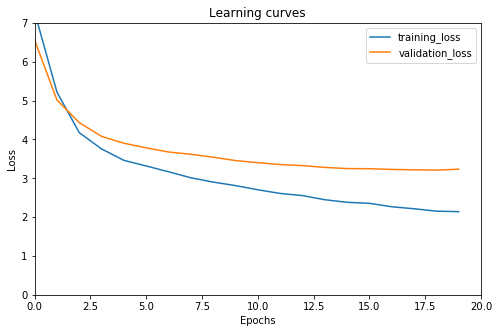

In [25]:
import matplotlib.pyplot as  plt
def plot_learning_curves(history, title=None):
    pd.DataFrame(history).plot(figsize=(8,5))
    plt.title('Learning curves')
    plt.xlim(0,20)
    plt.grid(False)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.gca().set_ylim(0,7) #设置坐标轴范围, x轴范围是epochs的个数
    plt.show()
plot_learning_curves(adict)

In [26]:
print(adict)

{'training_loss': [7.286, 5.225, 4.177, 3.757, 3.463, 3.318, 3.169, 3.014, 2.903, 2.813, 2.705, 2.611, 2.555, 2.449, 2.382, 2.356, 2.268, 2.216, 2.154, 2.141], 'validation_loss': [6.561, 5.019, 4.436, 4.08, 3.904, 3.784, 3.678, 3.619, 3.544, 3.457, 3.403, 3.354, 3.328, 3.281, 3.251, 3.247, 3.229, 3.219, 3.211, 3.235]}


In [ ]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1,units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        predictions, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoding_outputs)
        attention_weights = tf.reshape(attention_weights, (-1,))#length=16的向量
        attention_matrix[t] = attention_weights.numpy()#attention_weights是一个tensor，用numpy（）取出它的值
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    #attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    #plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results

In [54]:
#Caution: 在不画图的时候一定要将下面两行代码注释掉
import matplotlib.ticker as ticker
#-------------------lstm----------------
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    #这里的encoding_hidden在lstm情况下需要改一下维度
    encoding_hidden = [tf.zeros((1,units)),tf.zeros((1,units))]
    
    encoding_outputs, encoding_hidden, encoding_c = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    decoding_state = encoding_c
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        predictions, decoding_hidden, attention_weights, decoding_state = decoder(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
        attention_weights = tf.reshape(attention_weights, (-1,))#length=16的向量
        attention_matrix[t] = attention_weights.numpy()#attention_weights是一个tensor，用numpy（）取出它的值
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    
    #在不画图的时候一定要将下面两行代码注释掉
    #attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    #plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results

In [ ]:
translate(u'<start> water white salt tomatoes eggs <end>')

In [ ]:
translate(u'skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces, ')
translate(u'condensed cream mushroom soup package dry onion soup mix water pot roast, ')
translate(u'purpose flour baking soda salt butter brown sugar eggs beaten mashed overripe bananas, ')

In [ ]:
# preheat oven to 350 degrees f 175 degrees c . in a medium bowl , mix together the ground beef , and milk . bake in preheated oven for 45 minutes , or until chicken is cooked through .
# in a medium bowl , mix together the soup , and onion soup mix . cook on low for 8 to 10 minutes .
# preheat oven to 350 degrees f 175 degrees c . grease and flour a 9x13 inch baking pan . in a large bowl , combine flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder , and salt . stir in the flour , baking powder

Input: <start> tomatoes eggs sugar salt <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a large bowl , combine the tomatoes , eggs and sugar . mix well and pour in the mixture . cover and bake for 30 minutes . remove from oven and let cool . <end> 


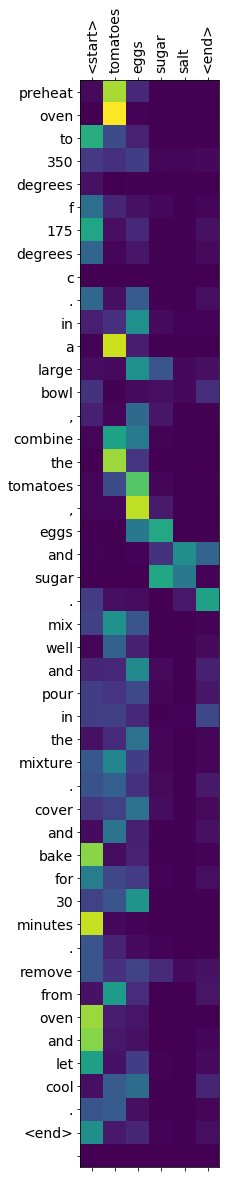

'preheat oven to 350 degrees f 175 degrees c . in a large bowl , combine the tomatoes , eggs and sugar . mix well and pour in the mixture . cover and bake for 30 minutes . remove from oven and let cool . <end> '

In [55]:
translate('<start> tomatoes eggs sugar salt <end>')

Input: <start> purpose flour baking soda salt butter brown sugar eggs beaten mashed overripe bananas <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking pan . in a large bowl , stir together flour , baking soda , and salt . cut in butter until crumbly . beat in eggs , one at a time , then stir in eggs . add bananas and bananas stir until batter is just combined . pour batter into prepared pan . bake in preheated oven for 45 to 50 minutes , or until a toothpick inserted into center of cake comes out clean . <end> 


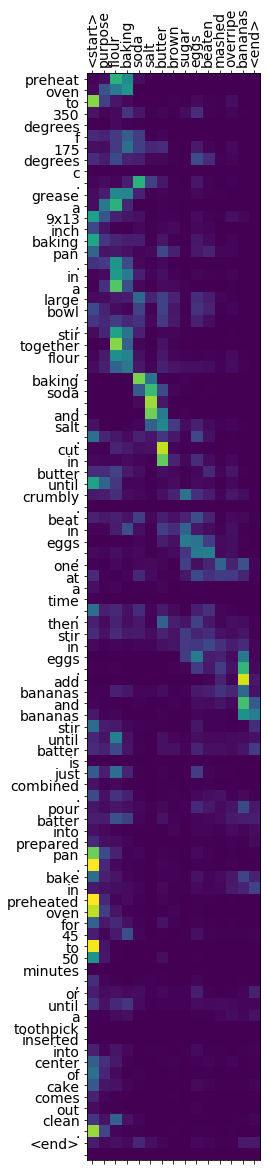

'preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking pan . in a large bowl , stir together flour , baking soda , and salt . cut in butter until crumbly . beat in eggs , one at a time , then stir in eggs . add bananas and bananas stir until batter is just combined . pour batter into prepared pan . bake in preheated oven for 45 to 50 minutes , or until a toothpick inserted into center of cake comes out clean . <end> '

In [57]:
translate('<start> purpose flour baking soda salt butter brown sugar eggs beaten mashed overripe bananas <end>')

In [ ]:
#print(reference_meteor)

In [28]:
#----------------------BLEU and Meteor------------------------------
candidates = []
candidates_meteor = []
for sample1 in clean_summaries[0:192]:
    #res = translate(sample1+', ')
    res = translate(sample1)
    candidates_meteor.append(res)
    candidates.append(res.split(' '))

Input: <start> skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a large skillet over medium high heat , melt butter . add chicken and chicken breasts , onion , and onion . mix well . pour mixture into a 9x13 inch baking dish . bake in the preheated oven for 45 minutes , or until golden brown . <end> 
Input: <start> condensed cream mushroom soup package dry onion soup mix water pot roast <end>
Predicted translation: in a medium bowl , mix together soup , soup mix , water , and water . place roast on the preheated grill , and cook for 1 hour , or until the pork is tender . <end> 
Input: <start> purpose flour baking soda salt butter brown sugar eggs beaten mashed overripe bananas <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking pan . in a large bowl , stir together flour , baking soda

Input: <start> cornstarch cold water white sugar soy sauce cider vinegar clove garlic minced ground ginger ground black pepper skinless chicken thighs <end>
Predicted translation: whisk together the cornstarch , water , sugar , soy sauce , vinegar , and garlic in a bowl . pour the chicken mixture into the prepared baking dish . cover the dish with plastic wrap and refrigerate until cold , about 1 hour . <end> 
Input: <start> avocados peeled pitted mashed lime juiced salt diced onion chopped fresh cilantro roma plum tomatoes diced minced garlic pinch ground cayenne pepper optional <end>
Predicted translation: in a medium bowl , mix together the avocados , lime juice , salt , onion , cilantro , and basil . cover and refrigerate for at least 1 hour before serving . <end> 
Input: <start> purpose flour baking soda baking powder butter softened white sugar egg vanilla extract <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease and flour a 9x13 inch pan . in a la

Input: <start> uncooked white rice milk divided white sugar salt egg beaten golden raisins butter vanilla extract <end>
Predicted translation: combine the rice and 1 cup milk in a saucepan over medium heat , and cook , stirring constantly , until the mixture is thick and smooth . remove from heat and stir in the sugar , salt , and egg . stir in the eggs , raisins , and butter . pour the mixture into the prepared baking dish . refrigerate until set , about 30 minutes . <end> 
Input: <start> ground beef egg onion chopped milk dried bread crumbs salt pepper taste brown sugar prepared mustard ketchup <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a large bowl , combine the ground beef , egg , onion , milk and bread crumbs . mix well and set aside . in a separate bowl , mix brown sugar and mustard . pour into a 9x13 inch baking dish . bake at 350 degrees f 175 degrees c for 45 minutes , or until the top is golden brown . <end> 
Input: <start> pound pork tender

Input: <start> eggs purpose flour milk vegetable oil white sugar baking powder salt vanilla extract <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking dish . beat eggs in a bowl . beat in flour , milk , and vegetable oil . stir in the sugar , baking powder , and salt . stir in the eggs one at a time , then stir in the batter . pour batter into prepared pan . bake in preheated oven for 45 to 50 minutes , or until a toothpick inserted into the center of the cake comes out clean . <end> 
Input: <start> butter heavy cream clove garlic crushed freshly grated parmesan cheese chopped fresh parsley <end>
Predicted translation: melt butter in a saucepan over medium heat . stir in the heavy cream , and cook until the butter is melted and the mixture is smooth , about 5 minutes . stir in the garlic , and cook until the mixture is thick and the mixture is smooth , about 5 minutes . stir in the parsley and parsley . <end> 
Input: <start> purpose flo

Input: <start> package oreo chocolate sandwich cookies divided package philadelphia cream cheese softened baker semi sweet baking chocolate melted <end>
Predicted translation: heat oven to 350 degrees f . grease cookie sheets . in large bowl , mix together cookie crumbs and 1 1/2 cups of the cookies into bottom of 9 inch springform pan . bake in preheated oven until crust is set , about 15 minutes . sprinkle with remaining cake mix . bake 25 min . or until top is melted . cool . in a large bowl , beat cream cheese until smooth and fluffy . stir in pudding until smooth . pour into prepared pan . bake in the preheated oven until set , about 25 minutes . remove from oven and cool on baking sheet . <end> 
Input: <start> cloves garlic minced light olive oil dried basil salt ground black pepper lemon juice fresh parsley chopped fillets salmon <end>
Predicted translation: preheat oven to 400 degrees f 200 degrees c . in a small bowl , combine garlic , olive oil , basil , basil , salt , and pe

Input: <start> purpose flour yellow cornmeal white sugar salt baking powder egg milk vegetable oil <end>
Predicted translation: preheat oven to 400 degrees f 200 degrees c . grease a baking sheet . in a large bowl , combine flour , cornmeal , sugar , salt , baking powder , and salt . mix in egg , milk , and oil . pour into prepared pan . bake in preheated oven for 45 minutes , or until a toothpick inserted into the center of the loaf comes out clean . <end> 
Input: <start> butter onion chopped package frozen chopped broccoli chicken broth pound loaf processed cheese food cubed milk garlic powder cornstarch water <end>
Predicted translation: melt butter in a large saucepan over medium heat . add onion cook and stir until onion is translucent , about 5 minutes . stir in chicken broth and cook until tender , about 5 minutes . stir in chicken broth and cook until heated through , about 5 minutes . add milk and stir until cheese is melted and smooth . <end> 
Input: <start> artichoke hearts 

Input: <start> dijon mustard honey mayonnaise steak sauce skinless boneless chicken breast <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a medium bowl , mix together mustard , honey , mayonnaise , and steak sauce . pour into a 9x13 inch baking dish . bake in the preheated oven for 1 hour , or until chicken is no longer pink and juices run clear . <end> 
Input: <start> egg milk shredded cheddar cheese quick cooking oats salt pound ground beef ketchup packed brown sugar prepared mustard <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a medium bowl , beat egg yolks and milk . add milk , cheddar cheese , oats , salt and mustard . mix well and pour into prepared pan . bake in preheated oven for 1 hour , or until cheese is melted and bubbly . <end> 
Input: <start> butter prepared dijon style mustard fresh lemon juice chopped garlic chopped fresh parsley medium raw shrimp shelled deveined tails attached <end>
Predicted translation:

Input: <start> tilapia fillets fresh lemon juice butter melted clove garlic finely chopped dried parsley flakes pepper taste <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . place the tilapia fillets in a shallow baking dish . sprinkle lemon juice over the fish . sprinkle with lemon juice , and garlic sprinkle over the fish . bake in the preheated oven until fish flakes easily with a fork , about 15 minutes . <end> 
Input: <start> uncooked egg noodles pound lean ground beef onion chopped cloves garlic minced green bell pepper chopped sliced pepperoni sausage pizza sauce milk shredded mozzarella cheese <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . bring a large pot of lightly salted water to a boil . add egg noodles and cook until tender but still firm , about 5 minutes . drain well . in a large skillet over medium heat , brown the ground beef and onion . drain off grease . stir in the onion and garlic . cook and stir until the beef

Input: <start> grated zucchini eggs beaten chopped onion purpose flour grated parmesan cheese shredded mozzarella cheese salt taste vegetable oil <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking dish . in a large bowl , combine zucchini , eggs , onion , flour , parmesan cheese , and salt . mix well . pour mixture into a 9x13 inch baking dish . bake in preheated oven for 30 minutes , or until golden brown . <end> 
Input: <start> whole kernel corn drained chicken broth chunk chicken black beans diced tomatoes green chile peppers drained <end>
Predicted translation: in a large saucepan , combine the corn , chicken broth , chicken broth , tomatoes , and green chile peppers . bring to a boil , reduce heat to medium low , and simmer for 20 minutes . <end> 
Input: <start> pork baby back ribs bottle barbecue sauce <end>
Predicted translation: place ribs in a large pot and cover with water . bring to a boil over high heat , reduce heat to medi

Input: <start> egg purpose flour beer baking powder purpose flour flaked coconut shrimp oil frying <end>
Predicted translation: in a medium bowl , whisk together the egg , flour , and baking powder . in a separate bowl , mix together the olive oil , and olive oil . add the flour mixture to the egg mixture , and stir until smooth . pour in the oil and shake to coat . heat oil in a deep fryer or large saucepan to 350 degrees f 175 degrees c . fry the wontons in batches until golden brown on both sides . <end> 
Input: <start> butter minced garlic soy sauce black pepper dried parsley boneless chicken thighs skin dried parsley taste <end>
Predicted translation: preheat an outdoor grill for medium high heat and lightly oil the grate . melt butter in a skillet over medium heat . add garlic and soy sauce , and cook until the chicken is no longer pink , about 5 minutes . stir in the soy sauce and black pepper . cook until chicken is no longer pink in the center , about 10 minutes . an instant r

Input: <start> package maple flavored sausage butter purpose flour whole milk salt pepper taste <end>
Predicted translation: in a large skillet over medium high heat , melt the butter . stir in the flour , milk , salt and pepper . cook and stir until the mixture is thick and the mixture is smooth . <end> 
Input: <start> pound ground pork sausage mustard powder salt eggs beaten milk slices white bread toasted cut cubes mild cheddar cheese shredded <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a large bowl , combine sausage , ground black pepper , ground baking powder , and salt . beat eggs , milk , and bread crumbs together in a bowl . pour into a 9x13 inch baking dish . bake in preheated oven until cheese is melted and bubbling , about 30 minutes . <end> 
Input: <start> crushed butter crackers garlic salt taste ground black pepper taste eggs beaten pork chops butter <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . melt butter in

Input: <start> pound standing beef rib roast salt ground black pepper garlic powder <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . place the roast in a large roasting pan or roasting pan . season with salt and pepper . roast in the preheated oven for 1 hour , or until the internal temperature of the roast reaches 145 degrees f 63 degrees c . remove from the oven and allow to rest for 5 minutes before slicing . <end> 
Input: <start> dijon mustard butter melted honey fresh bread crumbs finely chopped pe chopped fresh parsley fillets salmon salt pepper taste lemon wedges <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a medium bowl , mix together butter , melted butter , honey , bread crumbs , pecans , and salt . cut salmon in half , and stuff with lemon juice . place salmon in a shallow baking dish . bake in the preheated oven until fish flakes easily with a fork , about 20 minutes . <end> 
Input: <start> egg beaten dry bread crum

In [ ]:
Input: <start> skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . place chicken in a large bowl . add the butter and cook until the cheese is melted . <end> 
Input: <start> condensed cream mushroom soup package dry onion soup mix water pot roast <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a large bowl , mix together the chicken breasts in the heat and refrigerate for at least 1 hour . <end> 
Input: <start> purpose flour baking soda salt butter brown sugar eggs beaten mashed overripe bananas <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking pan . in a large bowl , stir together the flour , baking powder , and salt . stir in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla . mix in the flour , and vanilla 

In [29]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(references, candidates,weights=(1,0,0,0))
score1 = corpus_bleu(references, candidates,weights=(0.33,0.33,0.33,0))
score2 = corpus_bleu(references, candidates,weights=(0.25,0.25,0.25,0.25))
print(score,score1,score2)

0.46275009512753584 0.24652106125397244 0.18986165729170296


In [30]:
def calculate_given_item(given_ingredient, generated_recipe):
    '''
    given_ingredient = ['egg tomatoes','chicken']
    splitted_ingredient = [['egg','tomatoes'],['chicken']]
    generated_recipe = [['use','egg'],['use','chicken'],...]
    '''
    
    total_score = 0
    extra_score = 0
    splitted_ingredient = []
    for bstr in given_ingredient: 
        splitted_ingredient.append(bstr.split(' '))
    

    for index, each_sample in enumerate(splitted_ingredient):
        #count1 covered items
        #count2 extra items
        count1 = 0
        count2 = 0
        for each_word in each_sample:
            #generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in generated_recipe[index]:
                count1 += 1
            else:
                count2 += 1
        extra_score += count2 / len(each_sample)
        total_score += count1 / len(each_sample)
#-------------------------------------------------------------------------
    for index, each_recipe in enumerate(generated_recipe):
        #count1 covered items
        #count2 extra items
        extra_item = 0
        for each_word in each_recipe:
            #generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in input_tokenizer.word_index and each_word not in splitted_ingredient[index]:
                extra_item += 1
                  
#--------------------------------------------------------------------------      
    
    total_score = total_score / len(given_ingredient)
    
    return total_score, extra_item

'''
#testing set
given_ingredient = ['egg tomatoes','chicken banana']
generated_recipe = [['tomatoes','use'],['banana','chicken']]
cover_item, extra_item = calculate_given_item(given_ingredient, generated_recipe)
print(cover_item,extra_item)
'''

"\n#testing set\ngiven_ingredient = ['egg tomatoes','chicken banana']\ngenerated_recipe = [['tomatoes','use'],['banana','chicken']]\ncover_item, extra_item = calculate_given_item(given_ingredient, generated_recipe)\nprint(cover_item,extra_item)\n"

In [31]:
cover_item, extra_item = calculate_given_item(given_ingredient, candidates)
print(cover_item,extra_item)

0.4784406210896745 16


In [32]:
print(reference_meteor)

['place the chicken , butter , soup , and onion in a slow cooker , and fill with enough water to cover . cover , and cook for 5 to 6 hours on high . about 30 minutes before serving , place the torn biscuit dough in the slow cooker . cook until the dough is no longer raw in the center .', 'in a slow cooker , mix cream of mushroom soup , dry onion soup mix and water . place pot roast in slow cooker and coat with soup mixture . cook on high setting for 3 to 4 hours , or on low setting for 8 to 9 hours .', 'preheat oven to 350 degrees f 175 degrees c . lightly grease a 9x5 inch loaf pan . in a large bowl , combine flour , baking soda and salt . in a separate bowl , cream together butter and brown sugar . stir in eggs and mashed bananas until well blended . stir banana mixture into flour mixture stir just to moisten . pour batter into prepared loaf pan . bake in preheated oven for 60 to 65 minutes , until a toothpick inserted into center of the loaf comes out clean . let bread cool in pan f

In [33]:
print(candidates_meteor)

['preheat oven to 350 degrees f 175 degrees c . in a large skillet over medium high heat , melt butter . add chicken and chicken breasts , onion , and onion . mix well . pour mixture into a 9x13 inch baking dish . bake in the preheated oven for 45 minutes , or until golden brown . <end> ', 'in a medium bowl , mix together soup , soup mix , water , and water . place roast on the preheated grill , and cook for 1 hour , or until the pork is tender . <end> ', 'preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking pan . in a large bowl , stir together flour , baking soda , and salt . cut in butter until crumbly . beat in eggs , one at a time , then stir in eggs . add bananas and bananas stir until batter is just combined . pour batter into prepared pan . bake in preheated oven for 45 to 50 minutes , or until a toothpick inserted into center of cake comes out clean . <end> ', 'preheat oven to 350 degrees f 175 degrees c . grease and flour a 9x13 inch pan . in a large bowl ,

In [ ]:
translate(u'chicken, water, salt, pepper, ')

In [ ]:
translate(u'steak, salt, sugar, eggs, ')

In [ ]:
translate(u'butter, pieces, chicken, ')

In [ ]:
translate(u'chicken butter onion biscuit dough torn pieces, ')